Q1

N=4, dim=2^4=16, nnz=36, build time=0.0004s
N=6, dim=2^6=64, nnz=256, build time=0.0010s
N=8, dim=2^8=256, nnz=1140, build time=0.0034s
N=10, dim=2^10=1024, nnz=6144, build time=0.0131s
N=12, dim=2^12=4096, nnz=26824, build time=0.0433s
N=14, dim=2^14=16384, nnz=131072, build time=0.1432s
N=16, dim=2^16=65536, nnz=564084, build time=0.6440s


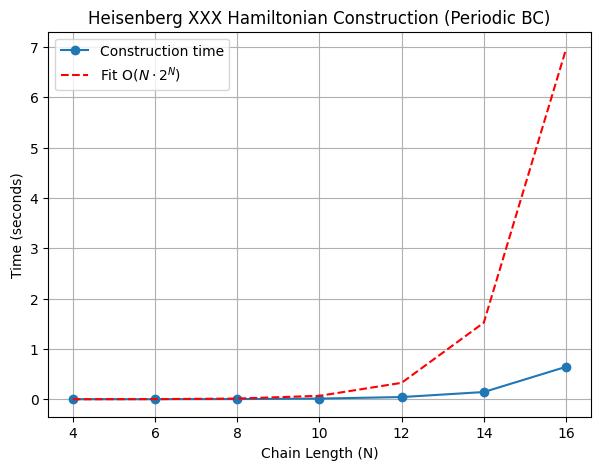

In [3]:

import numpy as np
from scipy.sparse import coo_matrix
import time
import matplotlib.pyplot as plt

def build_heisenberg_xxx(N, J=1.0):
   
    dim = 2**N

    # Precompute S^z_i for each basis state s
    s_z_state = np.zeros((dim, N), dtype=np.float64)
    for s in range(dim):
        for i in range(N):
            # If bit i is 1 => spin up (+1/2), else spin down (-1/2)
            s_z_state[s, i] = 0.5 if ((s >> i) & 1) else -0.5

    def flip_spin(state, i):
        # Flip bit i in 'state'
        return state ^ (1 << i)

    row, col, data = [], [], []

    # Build Hamiltonian entries
    for s in range(dim):
        # Diagonal part: sum_i S^z_i * S^z_{(i+1)%N}
        diag_val = 0.0
        for i in range(N):
            j = (i + 1) % N
            diag_val += s_z_state[s, i] * s_z_state[s, j]

        if diag_val != 0.0:
            row.append(s)
            col.append(s)
            data.append(diag_val)

        # Off-diagonal (flip-flop): S^+_i S^-_{i+1} + S^-_i S^+_{i+1}
        for i in range(N):
            j = (i + 1) % N
            bit_i = (s >> i) & 1
            bit_j = (s >> j) & 1
            # S^+_i S^-_j
            if bit_i == 0 and bit_j == 1:
                s_prime = flip_spin(flip_spin(s, i), j)
                row.append(s_prime)
                col.append(s)
                data.append(0.5)
            # S^-_i S^+_j
            if bit_i == 1 and bit_j == 0:
                s_prime = flip_spin(flip_spin(s, i), j)
                row.append(s_prime)
                col.append(s)
                data.append(0.5)

    # Build in COO format, scale by J, then convert to CSR
    H_coo = coo_matrix((data, (row, col)), shape=(dim, dim), dtype=np.float64)
    H_coo.data *= J
    return H_coo.tocsr()

def main():
    # Range of N values to test
    Ns = [4, 6, 8, 10, 12, 14, 16]
    times = []
    fit_times = []
    c_ref = None

    for idx, N in enumerate(Ns):
        start = time.perf_counter()
        H = build_heisenberg_xxx(N, J=1.0)
        elapsed = time.perf_counter() - start
        times.append(elapsed)

        # Anchor reference curve ~ c * N * 2^N at the first data point
        if idx == 0:
            c_ref = elapsed / (N * 2**N)
        fit_times.append(c_ref * N * 2**N)

        print(f"N={N}, dim=2^{N}={2**N}, nnz={H.nnz}, build time={elapsed:.4f}s")

    plt.figure(figsize=(7,5))
    plt.plot(Ns, times, 'o-', label='Construction time')
    plt.plot(Ns, fit_times, 'r--', label=r'Fit $\mathrm{O}(N \cdot 2^N)$')
    plt.xlabel("Chain Length (N)")
    plt.ylabel("Time (seconds)")
    plt.title("Heisenberg XXX Hamiltonian Construction (Periodic BC)")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


Q2

In [4]:

import numpy as np

def qr_diagonalize_iterative(H, max_iter=1000, tol=1e-12):
  
    A = H.copy().astype(float)
    n = A.shape[0]
    Q_accum = np.eye(n)

    for iteration in range(max_iter):
        Q, R = np.linalg.qr(A)
        A_next = R @ Q
        Q_accum = Q_accum @ Q

        # Check convergence by the off-diagonal norm
        off_diag = A_next - np.diag(np.diag(A_next))
        if np.linalg.norm(off_diag, ord='fro') < tol:
            A = A_next
            break
        A = A_next

    return A, Q_accum

def qr_diagonalize_recursive(H, iteration=0, max_iter=1000, tol=1e-12, memo=None):
    """
    Recursive (top-down) QR algorithm with a simple dynamic programming (memo) approach.
    Returns the approximate diagonal form of H after convergence or reaching max_iter.
    """
    if memo is None:
        memo = {}
        memo[0] = H.astype(float)

    # If we have a cached result for this iteration, return it
    if iteration in memo:
        A = memo[iteration]
    else:
        A = memo[iteration - 1]

    # Check stop conditions
    if iteration >= max_iter:
        return A
    off_diag = A - np.diag(np.diag(A))
    if np.linalg.norm(off_diag, ord='fro') < tol:
        return A

    # Perform QR on A
    Q, R = np.linalg.qr(A)
    A_next = R @ Q
    memo[iteration + 1] = A_next

    return qr_diagonalize_recursive(A_next, iteration + 1, max_iter, tol, memo)

def main():
    # Example: create a random symmetric (Hermitian) matrix of size n
    n = 5
    np.random.seed(42)
    M = np.random.randn(n, n)
    # Make M symmetric
    H = 0.5 * (M + M.T)

    print("Initial matrix H:")
    print(H)

    # 1) Iterative (bottom-up) QR
    H_diag_iter, Q_iter = qr_diagonalize_iterative(H, max_iter=200, tol=1e-12)
    print("\nIterative QR: approximate diagonal matrix:")
    print(np.round(H_diag_iter, 4))
    print("Off-diagonal norm:", np.linalg.norm(H_diag_iter - np.diag(np.diag(H_diag_iter))))

    # 2) Recursive (top-down) QR
    H_diag_rec = qr_diagonalize_recursive(H, iteration=0, max_iter=200, tol=1e-12)
    print("\nRecursive QR: approximate diagonal matrix:")
    print(np.round(H_diag_rec, 4))
    print("Off-diagonal norm:", np.linalg.norm(H_diag_rec - np.diag(np.diag(H_diag_rec))))

    # Compare with NumPy's built-in eigen-decomposition
    w, v = np.linalg.eigh(H)
    print("\nEigenvalues from np.linalg.eigh:")
    print(np.round(w, 4))

if __name__ == "__main__":
    main()

Initial matrix H:
[[ 0.49671415 -0.18620063  0.09213542  0.48037116  0.6157477 ]
 [-0.18620063  1.57921282  0.15085249 -0.74115275  0.15839187]
 [ 0.09213542  0.15085249  0.24196227 -0.79951646 -0.82869481]
 [ 0.48037116 -0.74115275 -0.79951646 -0.90802408 -1.41852594]
 [ 0.6157477   0.15839187 -0.82869481 -1.41852594 -0.54438272]]

Iterative QR: approximate diagonal matrix:
[[-2.8105 -0.     -0.     -0.      0.    ]
 [-0.      1.9911  0.     -0.     -0.    ]
 [ 0.     -0.      0.9715  0.      0.    ]
 [-0.      0.     -0.      0.4895 -0.    ]
 [-0.     -0.     -0.      0.      0.2238]]
Off-diagonal norm: 8.757971442498324e-13

Recursive QR: approximate diagonal matrix:
[[-2.8105 -0.     -0.     -0.      0.    ]
 [-0.      1.9911  0.     -0.     -0.    ]
 [ 0.     -0.      0.9715  0.      0.    ]
 [-0.      0.     -0.      0.4895 -0.    ]
 [-0.     -0.     -0.      0.      0.2238]]
Off-diagonal norm: 8.757971442498324e-13

Eigenvalues from np.linalg.eigh:
[-2.8105  0.2238  0.4895  0.97

Q3

H has eigenvalues roughly in [-2.803, 1.500]


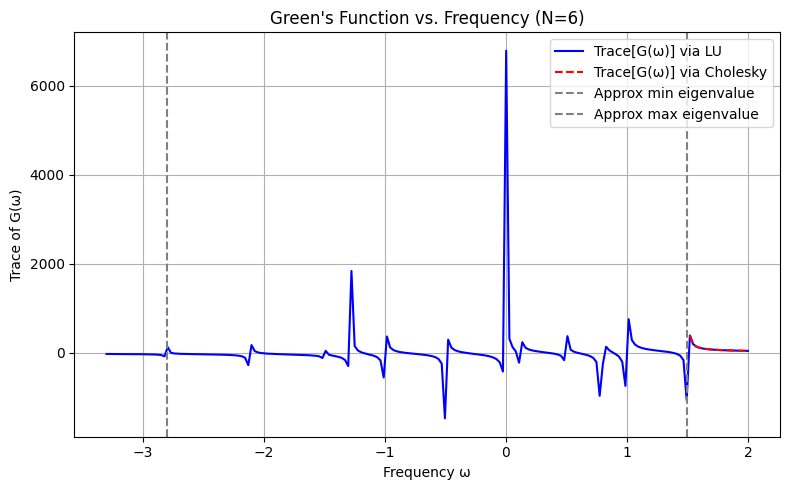

1) As omega approaches an eigenvalue of H, the matrix (omega I - H) becomes nearly singular, causing the trace of G(omega) to spike.
2) These sharp peaks are the resonances, where the Green's function diverges due to the denominator approaching zero.
3) Between eigenvalues, the trace remains relatively small, reflecting a more stable inverse.
4) The dashed vertical lines mark the approximate minimum and maximum eigenvalues, indicating the energy range where resonances occur.


In [6]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import lu_factor, lu_solve, cholesky
import matplotlib.pyplot as plt

def build_heisenberg_xxx(N, J=1.0):
   
    dim = 2**N
    s_z_state = np.zeros((dim, N), dtype=np.float64)
    for s in range(dim):
        for i in range(N):
            s_z_state[s, i] = 0.5 if ((s >> i) & 1) else -0.5

    def flip_spin(state, i):
        return state ^ (1 << i)

    row, col, data = [], [], []
    for s in range(dim):
        diag_val = 0.0
        for i in range(N):
            j = (i + 1) % N
            diag_val += s_z_state[s, i] * s_z_state[s, j]
        if diag_val != 0.0:
            row.append(s)
            col.append(s)
            data.append(diag_val)

        # Off-diagonal: flip-flop
        for i in range(N):
            j = (i + 1) % N
            bit_i = (s >> i) & 1
            bit_j = (s >> j) & 1
            # S^+_i S^-_j
            if bit_i == 0 and bit_j == 1:
                s_prime = flip_spin(flip_spin(s, i), j)
                row.append(s_prime)
                col.append(s)
                data.append(0.5)
            # S^-_i S^+_j
            if bit_i == 1 and bit_j == 0:
                s_prime = flip_spin(flip_spin(s, i), j)
                row.append(s_prime)
                col.append(s)
                data.append(0.5)

    H_coo = coo_matrix((data, (row, col)), shape=(dim, dim), dtype=np.float64)
    H_coo.data *= J
    return H_coo.tocsr()

def greens_function_lu(H, omega):
   
    # Convert to dense if H is sparse
    A = omega * np.eye(H.shape[0]) - H.toarray() if hasattr(H, 'toarray') else (omega * np.eye(H.shape[0]) - H)
    lu, piv = lu_factor(A)
    N = A.shape[0]
    I = np.eye(N)
    G = np.zeros_like(A)
    for col in range(N):
        e_col = I[:, col]
        x_col = lu_solve((lu, piv), e_col)
        G[:, col] = x_col
    return G

def greens_function_cholesky(H, omega):
    """
    Solve G(omega) = (omega I - H)^(-1) via Cholesky factorization.
    Requires (omega I - H) to be positive definite. If not, this may fail.
    """
    A = omega * np.eye(H.shape[0]) - H.toarray() if hasattr(H, 'toarray') else (omega * np.eye(H.shape[0]) - H)
    L = cholesky(A, lower=True)
    N = A.shape[0]
    I = np.eye(N)
    G = np.zeros_like(A)
    for col in range(N):
        y = np.linalg.solve(L, I[:, col])
        x = np.linalg.solve(L.T, y)
        G[:, col] = x
    return G

def main():
    # 1) Build a small Heisenberg Hamiltonian, e.g., N=4 or N=6 for demonstration
    # If you truly want N=30, be aware 2^30 = 1,073,741,824 (which is huge).
    # We'll do N=6 for a demonstration. 
    N = 6
    H_sparse = build_heisenberg_xxx(N, J=1.0)

    # 2) Get approximate min/max eigenvalues for choosing a frequency range
    # For moderate N, we can do a partial diagonalization with scipy.sparse.linalg.eigsh
    # to find the lowest/highest eigenvalues. We'll do k=2 for min & max.
    # (Alternatively, you could convert to dense for small N and do np.linalg.eigh.)
    k = min(H_sparse.shape[0] - 1, 2)  # safety
    # smallest
    evals_small, _ = eigsh(H_sparse, k=k, which='SA')
    # largest
    evals_large, _ = eigsh(H_sparse, k=k, which='LA')
    lam_min = np.min(evals_small)
    lam_max = np.max(evals_large)

    print(f"H has eigenvalues roughly in [{lam_min:.3f}, {lam_max:.3f}]")

    # 3) Sweep frequencies in [lam_min - 0.5, lam_max + 0.5]
    w_vals = np.linspace(lam_min - 0.5, lam_max + 0.5, 200)
    trace_lu = []
    trace_chol = []

    for w in w_vals:
        # A = wI - H might be singular if w is close to an eigenvalue => large trace => resonance
        # We'll skip if near-singular, or just compute and handle possible errors
        A = (w * np.eye(H_sparse.shape[0]) - H_sparse.toarray())
        condA = np.linalg.cond(A)
        if condA > 1e12:
            trace_lu.append(np.nan)
            trace_chol.append(np.nan)
            continue

        # LU-based G(omega)
        G_lu = greens_function_lu(H_sparse, w)
        tr_lu = np.trace(G_lu)
        trace_lu.append(tr_lu)

        # If wI - H is not positive definite, Cholesky may fail => catch it
        try:
            G_chol = greens_function_cholesky(H_sparse, w)
            trace_chol.append(np.trace(G_chol))
        except np.linalg.LinAlgError:
            trace_chol.append(np.nan)

    # 4) Plot
    plt.figure(figsize=(8,5))
    plt.plot(w_vals, trace_lu, 'b-', label="Trace[G(ω)] via LU")
    plt.plot(w_vals, trace_chol, 'r--', label="Trace[G(ω)] via Cholesky")
    plt.axvline(lam_min, color='gray', linestyle='--', label="Approx min eigenvalue")
    plt.axvline(lam_max, color='gray', linestyle='--', label="Approx max eigenvalue")
    plt.xlabel("Frequency ω")
    plt.ylabel("Trace of G(ω)")
    plt.title(f"Green's Function vs. Frequency (N={N})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
print(
    "1) As omega approaches an eigenvalue of H, the matrix (omega I - H) becomes nearly singular, causing the trace of G(omega) to spike.\n"
    "2) These sharp peaks are the resonances, where the Green's function diverges due to the denominator approaching zero.\n"
    "3) Between eigenvalues, the trace remains relatively small, reflecting a more stable inverse.\n"
    "4) The dashed vertical lines mark the approximate minimum and maximum eigenvalues, indicating the energy range where resonances occur."
)

Q4

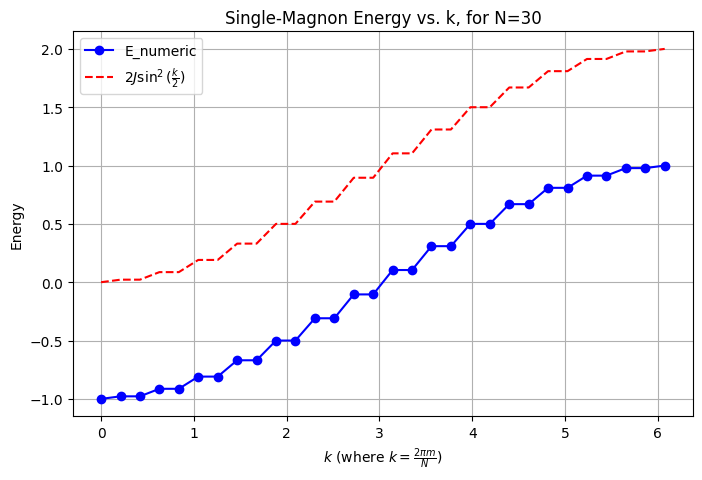

In [9]:

import numpy as np
import matplotlib.pyplot as plt

def build_single_magnon_matrix(N, J=1.0):
    """
    Build an N x N matrix representing the single-magnon subspace of the
    1D Heisenberg XXX chain (periodic boundary). Each basis state corresponds
    to exactly one spin-down among N sites.
    """
    M = np.zeros((N, N), dtype=float)
    # Off-diagonal elements: spin-down can 'hop' to neighbors
    for n in range(N):
        n_plus = (n + 1) % N
        n_minus = (n - 1) % N
        # Hopping amplitude -J/2 to left and right neighbors
        M[n, n_plus] += -0.5 * J
        M[n, n_minus] += -0.5 * J
    return M

def main_magnon_dispersion(N=30, J=1.0):
    """
    Diagonalize the single-magnon Hamiltonian of size N x N, then compare
    the numeric eigenvalues to the analytic dispersion:
      E(k) = 2J * sin^2(k/2),   k = 2 pi m / N,   m=0..N-1.
    Plot both as a function of k.
    """
    # 1) Build single-magnon matrix
    M = build_single_magnon_matrix(N, J)

    # 2) Numerical diagonalization
    w, v = np.linalg.eigh(M)  # w: eigenvalues, v: eigenvectors
    w_sorted = np.sort(w)

    # 3) Theoretical energies for k = 2 pi m / N
    ks = np.arange(N)                # 0..N-1
    k_vals = 2.0 * np.pi * ks / N
    E_theory = 2.0 * J * np.sin(k_vals / 2.0)**2
    E_theory_sorted = np.sort(E_theory)

    # 4) Plot numeric vs. theory vs. k
    plt.figure(figsize=(8,5))
    plt.plot(k_vals, w_sorted, 'bo-', label='E_numeric')
    plt.plot(k_vals, E_theory_sorted, 'r--', label=r'$2J \sin^2(\frac{k}{2})$')
    plt.xlabel(r"$k$ (where $k = \frac{2\pi m}{N}$)")
    plt.ylabel("Energy")
    plt.title(f"Single-Magnon Energy vs. k, for N={N}")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main_magnon_dispersion(N=30, J=1.0)
